In [1]:
import pandas as pd
import numpy as np
import os
import math
import random

os.makedirs('lscour_calcs', exist_ok=True)

# From Trampush et al., 2014
Trampush_velocities = {
    '50':1.2843137254901962,
    '25':0.8413867822318526,
    '75':1.6939077776156426
}

a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)


seconds_in_month = 2629800

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity

rho = 1000 # density of water (kg/m^3)
ps =  2650 # density of sediment (kg/m^3)
t_crit = 0.03 # critical shields stress

def estimate_tc(row):
    # Lamb et al., 2008
    return np.power(0.15*row['S [-]'], 0.25)
    
Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)

def Hbf_either(row): # Choose randomly whether to use flow depth from Dunne and Jerolmack, 2018
    # using flow velocity
    
    hc_dunne = Hbf_Dunne(row['S [-]'], row['t_c_bank'], rho, g)
    hc_velocity = row['discharge [cms]']/row['U [m/s]']/row['Width [m]']
    
    if random.randrange(0, 2, 1): # 1 = Velocity 0 = D & J
        return hc_velocity
    else:
        return hc_dunne
    
def tb_depth_slope(row):
    return rho*g*row['Hbf [m]']*row['S [-]']

def get_D50(row):
    D50_regression = float(D50_trampush(row['Hbf [m]'], row['S [-]']))/float(1000)
    D50_shields = (row['t_b']/(row['t_c']*(ps-rho)*g))

    if random.randrange(0, 2, 1):
        return D50_regression
    else:
        return D50_shields
    
def estimate_Cf(row):
    return (g*row['S [-]']*row['Hbf [m]'])/np.power(row['U [m/s]'], 2)

def L_b(row):
    return row['Hbf [m]']/row['S [-]']/1000

# Ma et al., 2017 D50

def n_Ma(D50):
    # Ma et al. [2017] n exponent
    return (1.322 / (1 + np.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
      
def a_Ma(D50):
    # Ma et al. [2017] alpha exponent
    return (0.859 / (1 + np.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036

def Qs_Ma(row):
    
    a_ma_rep = a_Ma(row['D50 [m]'])
    n_ma_rep = n_Ma(row['D50 [m]'])        
    
    tau_star = ((row['Hbf [m]'])*row['S [-]'])/(R*row['D50 [m]'])
    
    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m]'],3))
    
    return qs*row['Width [m]']

def t_adj(row):
    
    m2_per_s = float(row['Qs [cms]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['L_b [km]'])*1000 # m
    hbf = float(row['Hbf [m]'])*row['flood_multiple'] # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    # Return months
    return t_adj_s/seconds_in_month

def l_scour_GRL(row):
    
    a_ma_rep = a_Ma(row['D50 [m]'])
    n_ma_rep = n_Ma(row['D50 [m]']) 

    lscour_top = np.sqrt(R*g*(np.power(row['D50 [m]'],3)))*a_ma_rep*np.power((row['Hbf [m]']*row['flood_multiple'])*row['S [-]'], n_ma_rep)
    lscour_bottom = row['Hbf [m]']*(row['L_b [km]']*1000)*row['Cf']*np.power(R*row['D50 [m]'],n_ma_rep)
    lscour_Lb = np.power((row['Tscour [months]'])* 2.628e+6 * (lscour_top/lscour_bottom), 0.5)
    lscour_rep = lscour_Lb*(row['L_b [km]']*1000)

    return lscour_rep/1000
    
def l_scour_Tadj(row):
    
    return (row['L_b [km]']*1000)*np.sqrt((row['Tscour [months]']*seconds_in_month/(row['T_adj [months]']*seconds_in_month)))/1000


In [2]:
# Monte Carlo Simulations

global_avulsions = pd.read_csv(os.path.join('data', 'global_avulsion_db_merged.csv'))

num_reps = 20000

df_all = pd.DataFrame()

for rid, row in global_avulsions.iterrows():

    # Uniform distribution of slope within IQR
    
    print(row['Av_ID'])
    
    S = []
    
    if row['S_IQR [-]'] > 0:
        
        lower_bound = row['S [-]']-(row['S_IQR [-]']*0.5)
        upper_bound = row['S [-]']+(row['S_IQR [-]']*0.5)
        
        while len(S)<num_reps:
            slope = random.uniform(lower_bound, upper_bound)
            if slope > 0:
                S.append(slope)
    else:
        
        S = [row['S [-]']]*num_reps
    
    # Uniform distribution of widths using standard deviation
        
    if row['Width_std [m]'] > 0:
        widths = np.random.normal(row['Width [m]'], row['Width_std [m]'], num_reps)
    else:
        widths = [row['Width [m]']]*num_reps

    df = pd.DataFrame({'S [-]': S, 'Width [m]': widths})
    
    df['Av_ID'] = row['Av_ID']
    df['River'] = row['River']
    df['L_A [km]'] = row['L_A [km]']
    df['L_A_error [km]'] = row['L_A_error [km]']
#     df['t_c'] = df.apply(estimate_tc, axis=1)
    df['t_c'] = t_crit
  
    t_c_bank = []
    
    for _ in range(num_reps): t_c_bank.append(random.randrange(6, 11, 1))
    
    df['t_c_bank'] = t_c_bank    
    
    flood_multiple = []
    for _ in range(num_reps): flood_multiple.append(random.randrange(2, 5, 1)) # Floods are between 2 and 4 time bankfull
    # e.g. (Gibling 2006; Ganti et al. 2014a; Trower et al. 2018; Ganti et al., 2019)

    df['flood_multiple'] = flood_multiple
    
    # Flow velocity
    
    U = []
    for _ in range(num_reps): U.append(random.uniform(Trampush_velocities['25'], Trampush_velocities['75']))
    df['U [m/s]'] = U
    
    df['discharge [cms]'] = row['discharge [cms]']
    
    # Channel depths (Either Velocity or K&J)
        
    if row['Hbf [m] (recorded)'] > 0:  
        df['Hbf [m]'] = row['Hbf [m] (recorded)']
    else:
        df['Hbf [m]'] = df.apply(Hbf_either, axis=1)
    
    df['L_b [km]'] = df.apply(L_b, axis=1)
    
    df['t_b'] = df.apply(tb_depth_slope, axis=1)
    
    if row['D50 [m] (recorded)'] > 0:
        df['D50 [m]'] = row['D50 [m] (recorded)']
    else:
        df['D50 [m]'] = df.apply(get_D50, axis=1)
    
    if row['Cf'] > 0:
        df['Cf'] = row['Cf']
    else:
        df['Cf'] = df.apply(estimate_Cf, axis=1)
    
    # Sediment flux
    if row['D50 [m] (recorded)'] > 0:
        df['Qs [cms]'] = df.apply(Qs_Ma, axis=1)
    else:
        if row['WBMSed Qs [kgs]'] > 0:
            df['Qs [cms]'] = row['WBMSed Qs [kgs]']/ps
        else:
            df['Qs [cms]'] = df.apply(Qs_Ma, axis=1)
    
    # Tscour
    if row['Tscour [months]'] > 0:
        df['Tscour [months]'] = row['Tscour [months]']
    else:
        tscour_range = []
        for _ in range(num_reps): tscour_range.append(random.uniform(1.5, 2))
        df['Tscour [months]'] = tscour_range
        
    df['T_adj [months]'] = df.apply(t_adj, axis=1)
    
    if row['D50 [m] (recorded)'] > 0:
        df['l_scour [km]'] = df.apply(l_scour_GRL, axis=1)
    else:
        df['l_scour [km]'] = df.apply(l_scour_Tadj, axis=1)
    
    df.to_csv(os.path.join('lscour_calcs', row.Av_ID+'.csv'))
              
    df_all = df_all.append(df)
    

AFR0211_1998
ANGO2_2003
BS0115_1995
CA0067_1986
CA0194_2007


<ipython-input-1-c38a68185d70>:20: RuntimeWarning: invalid value encountered in log10
  D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)
<ipython-input-1-c38a68185d70>:113: RuntimeWarning: invalid value encountered in sqrt
  return (row['L_b [km]']*1000)*np.sqrt((row['Tscour [months]']*seconds_in_month/(row['T_adj [months]']*seconds_in_month)))/1000


CASP1_1991
JAVA12_1985
JAVA2_1984
JAVA3_1992
JAVA4_1973
JAVA5_1995
JAVA5_1998
JAVA5_2018
JAVA6_2010
JAVA7_1982
JAVA7_1990
JAVA7_2010
JAVA8_2018
JAVA9_2014
MALAWI1_2014


<ipython-input-1-c38a68185d70>:75: RuntimeWarning: overflow encountered in exp
  return (0.859 / (1 + np.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036
<ipython-input-1-c38a68185d70>:71: RuntimeWarning: overflow encountered in exp
  return (1.322 / (1 + np.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
<ipython-input-1-c38a68185d70>:85: RuntimeWarning: invalid value encountered in sqrt
  qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m]'],3))


PI0019_1989
PI0209_2006
PI0769_1982
SA0210_1996
SA0505_1999
SUMA2_2005
VENEZ1_1982
VENEZ2_1986
VENEZ2_2009
NILE
MAGDALENA
ORINOCO
RHINE
DANUBE
PARANA
MISS_MODERN
MISS_LAFOURCHE
HUANGHE_1930
MANGOKY
MANAMBOLO_2004
MORONDAVA_1979
SAMBAO_2004
FIHERENANA_2001


In [3]:
def IQR(dat):
    return np.nanpercentile(dat, 75)-np.nanpercentile(dat, 25)

df_grouped = df_all.groupby("Av_ID").agg([np.nanmedian, IQR, np.mean, np.std])

# avocado_prices.plot(kind = "scatter", y = "mean", legend = False, title = "Test", xerr = "std")

df_grouped

S [-]                                  Width [m]  \
                nanmedian       IQR      mean       std    nanmedian   
Av_ID                                                                  
AFR0211_1998     0.000349  0.000102  0.000348  0.000059   159.931780   
ANGO2_2003       0.003078  0.000086  0.003078  0.000049   225.791300   
BS0115_1995      0.000296  0.000293  0.000295  0.000170    88.674755   
CA0067_1986      0.000189  0.000104  0.000189  0.000060    94.897030   
CA0194_2007      0.002112  0.000739  0.002117  0.000425    37.847612   
CASP1_1991       0.000690  0.000238  0.000690  0.000138   132.375744   
DANUBE           0.000050  0.000000  0.000050  0.000000   870.000000   
FIHERENANA_2001  0.002231  0.000194  0.002231  0.000113    38.050000   
HUANGHE_1930     0.000064  0.000000  0.000064  0.000000   400.000000   
JAVA12_1985      0.000240  0.000098  0.000240  0.000056   113.772047   
JAVA2_1984       0.000317  0.000159  0.000318  0.000092    66.996699   
JAVA3_1992       0.000469  0.000169  0.000469  0.000097    26.945130   
JAVA4_1973       0.000638  0.000300  0.000639  0.000174    74.987936   
JAVA5_1995       0.000549  0.000258  0.000550  0.000150    46.917696   
JAVA5_1998       0.000599  0.000258  0.000598  0.000150    46.823439   
JAVA5_2018       0.000584  0.000310  0.000585  0.000180    46.966967   
JAVA6_2010       0.000442  0.000224  0.000443  0.000129    63.552636   
JAVA7_1982       0.000948  0.000264  0.000947  0.000153    37.854773   
JAVA7_1990       0.001005  0.000203  0.001006  0.000117    37.909623   
JAVA7_2010       0.000646  0.000264  0.000646  0.000153    38.046677   
JAVA8_2018       0.000563  0.000448  0.000564  0.000257    54.056668   
JAVA9_2014       0.000471  0.000462  0.000470  0.000269    41.632279   
MAGDALENA        0.000095  0.000000  0.000095  0.000000   850.000000   
MALAWI1_2014     0.000987  0.000185  0.000987  0.000107   125.567255   
MANAMBOLO_2004   0.000599  0.000102  0.000599  0.000059   505.590000   
MANGOKY          0.000769  0.000035  0.000769  0.000020   949.800000   
MISS_LAFOURCHE   0.000043  0.000000  0.000043  0.000000   880.000000   
MISS_MODERN      0.000043  0.000000  0.000043  0.000000   880.000000   
MORONDAVA_1979   0.001389  0.000063  0.001390  0.000036   188.920000   
NILE             0.000064  0.000000  0.000064  0.000000   500.000000   
ORINOCO          0.000060  0.000000  0.000060  0.000000  1400.000000   
PARANA           0.000040  0.000000  0.000040  0.000000  1350.000000   
PI0019_1989      0.000812  0.000212  0.000813  0.000122    83.019438   
PI0209_2006      0.000642  0.000193  0.000640  0.000111    60.402091   
PI0769_1982      0.002819  0.000717  0.002815  0.000413   154.205403   
RHINE            0.000110  0.000000  0.000110  0.000000   150.000000   
SA0210_1996      0.000332  0.000087  0.000332  0.000050    53.199887   
SA0505_1999      0.000116  0.000006  0.000116  0.000003    89.573282   
SAMBAO_2004      0.000565  0.000041  0.000565  0.000024   159.820000   
SUMA2_2005       0.001250  0.000704  0.001252  0.000406    85.441420   
VENEZ1_1982      0.000145  0.000127  0.000145  0.000073   102.138596   
VENEZ2_1986      0.001498  0.000145  0.001498  0.000083    29.112502   
VENEZ2_2009      0.001552  0.000059  0.001552  0.000034    28.861838   

                                                    L_A [km]       ...  \
                       IQR         mean        std nanmedian  IQR  ...   
Av_ID                                                              ...   
AFR0211_1998     39.674170   159.940560  29.293827     2.049  0.0  ...   
ANGO2_2003       72.677317   225.856068  54.501397    16.376  0.0  ...   
BS0115_1995      18.785513    88.613405  13.885308     7.780  0.0  ...   
CA0067_1986      24.514510    94.833196  17.946539    29.771  0.0  ...   
CA0194_2007      15.702750    37.815194  11.662701     2.459  0.0  ...   
CASP1_1991       46.180074   132.259533  34.273369     3.430  0.0  ...   
DANUBE            0.000000   870.000000  

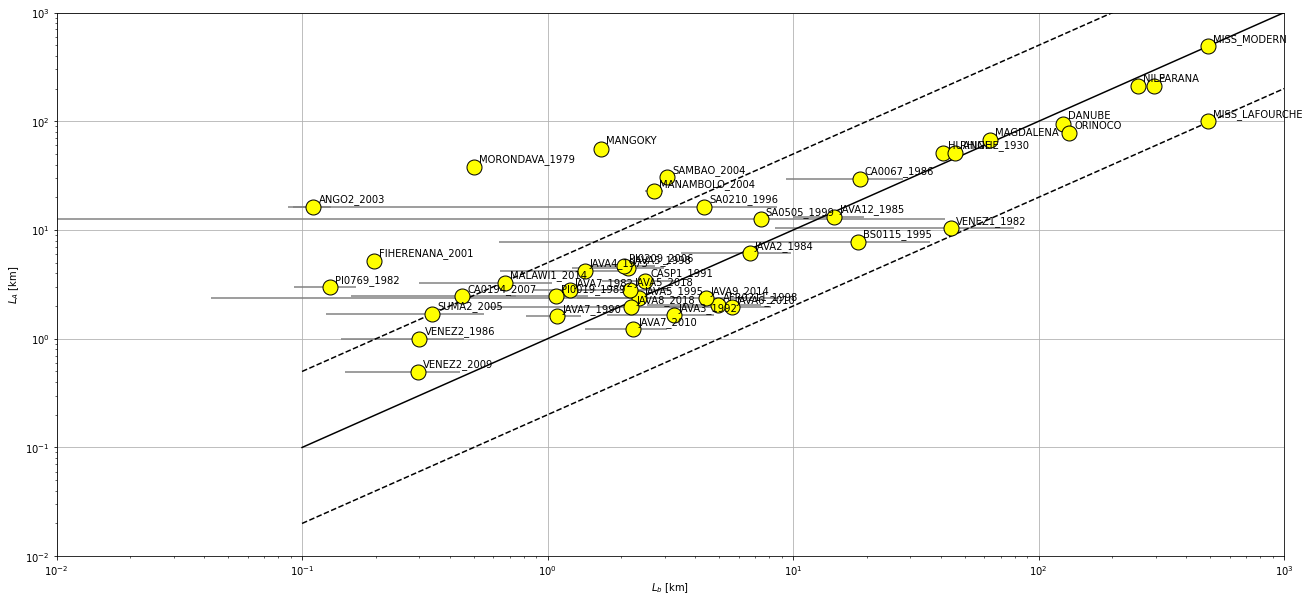

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(22, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['L_b [km]']['nanmedian'], df_grouped['L_A [km]']['nanmedian'], xerr=df_grouped['L_b [km]']['IQR']/2, yerr=df_grouped['L_A [km]']['IQR']/2, 
            fmt='o', ms=15, markerfacecolor='yellow', ecolor='grey', markeredgecolor='black')

plt.grid('on')
ax.set_xlabel('$L_b$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.01, top=1000)
ax.set_xlim(left=.01, right=1000)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['L_b [km]']['nanmedian'],row['L_A [km]']['nanmedian']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    
plt.show()

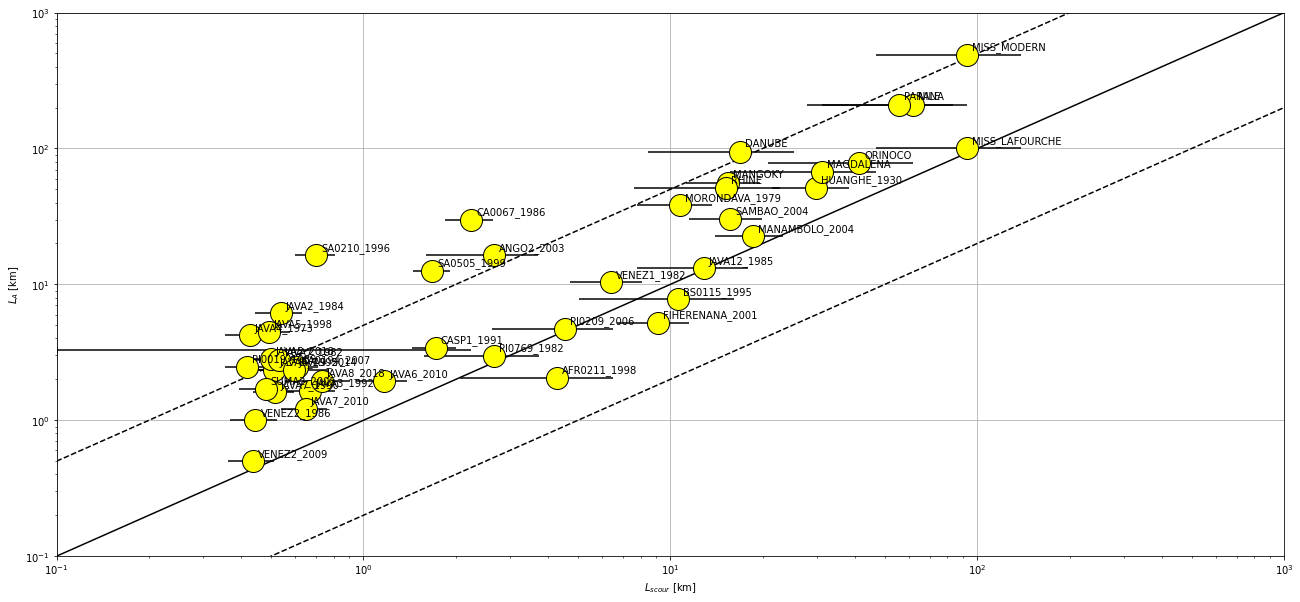

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(22, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['l_scour [km]']['nanmedian'], df_grouped['L_A [km]']['nanmedian'], xerr=df_grouped['l_scour [km]']['IQR']/2, yerr=df_grouped['L_A [km]']['IQR']/2, 
            fmt='o', ms=22, markerfacecolor='yellow', ecolor='black', markeredgecolor='black')
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['l_scour [km]']['nanmedian'],row['L_A [km]']['nanmedian']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    
plt.show()

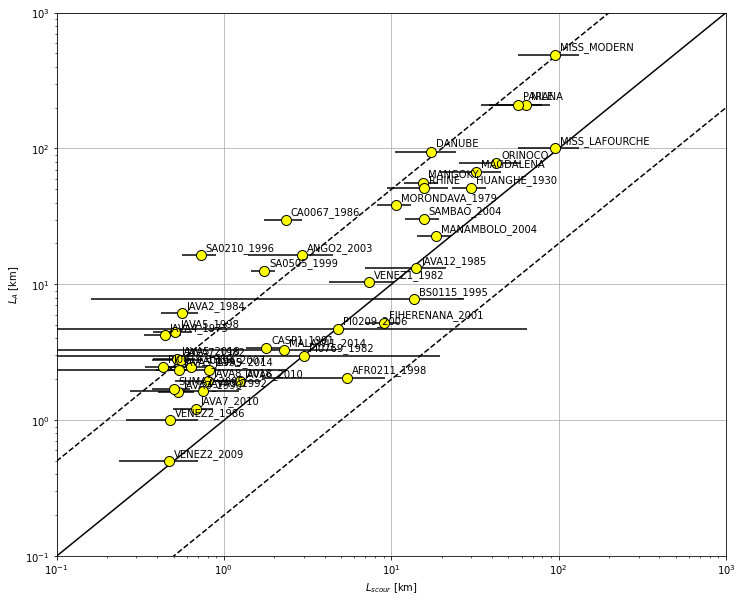

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(12, 10))
ax.set_xscale("log", nonpositive='clip')
ax.set_yscale("log", nonpositive='clip')

refplot = np.linspace(.1,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5

ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed') 

annotate_text = []

ax.errorbar(df_grouped['l_scour [km]']['mean'], df_grouped['L_A [km]']['mean'], xerr=df_grouped['l_scour [km]']['std'], yerr=df_grouped['L_A [km]']['std'], 
            fmt='o', ms=10, markerfacecolor='yellow', ecolor='black', markeredgecolor='black')
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)

for idx, row in df_grouped.iterrows():
    ax.annotate(idx, xy=(row['l_scour [km]']['mean'],row['L_A [km]']['mean']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    
plt.show()